# Modelo basado en transformers
En los modelos considerados anteriormente hemos llegado a alcanzar resultados excelentes. FastText clasifica perfectamente todas las frases con más de 12 palabras y llegamos a obtener tasas de acierto de 99.87% en frases de entre 7 y 12 palabras y del 98.37% en frases de menos de 7 palabras, manteniendo una latencia muy baja. Sin embargo, hemos visto que el modelo comete fallos que un humano no cometería derivados del hecho de que solo se fija en los n-gramas que tiene en su vocabulario, sin considerar palabras completas, y de que carece de mecanismos de atención. En este último enfoque, exploraremos si podemos solucionar estas limitaciones empleando un modelo BERT preentrenado en diversas lenguas. 

Emplearemos le modelo `distilbert-base-multilingual-cased` por varias razones:
- Está preentrenado sobre 104 lenguas, que incluyen todas las de nuestro dataset.
- Es más ligero que el modelo BERT original.
- Es *case-sensitive*, ya que sabemos que en algunos idiomas tienen un uso particular de las mayúsculas y minúsculas.

In [ ]:
# # Librerías necesarias
import os
import joblib
import pickle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from transformers import TFDistilBertModel, DistilBertTokenizer
from livelossplot import PlotLossesKerasTF
from utils import classification_metrics_report


/home/juan/miniconda3/envs/tf_complete/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Preprocesamiento de los datos

### Lectura y prepraración de los datos
Comenzamos leyendo las particiones de entrenamiento, validación y test que habíamos creado previamente. 

In [15]:
# Leemos los datos
df_train = pd.read_csv(os.path.join("data","raw","train.csv"))
df_val = pd.read_csv(os.path.join("data","raw","val.csv"))
df_test = pd.read_csv(os.path.join("data","raw","test.csv"))

# Veamos nuestro DataFrame
df_train.head(5)

# Separamos las variables que usaremos
train_texts = df_train["text"]
val_texts = df_val["text"]
test_texts = df_test["text"]

y_train = df_train["language"]
y_val = df_val["language"]
y_test = df_test["language"]

### Preprocesamiento
Eliminamos los números

In [16]:
# Eliminar números de cada conjunto de textos
train_texts = train_texts.str.replace(r'\d+', '', regex=True)
val_texts = val_texts.str.replace(r'\d+', '', regex=True)
test_texts = test_texts.str.replace(r'\d+', '', regex=True)

### Tokenización y vectorización

In [17]:
# Tokenizar los datasets (se truncan al tamaño de la ventana)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')


X_train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='tf')
X_val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, return_tensors='tf')
X_test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors='tf')

# Codificamos la variable objetivo
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

y_train_tensor = tf.convert_to_tensor(y_train_enc)
y_val_tensor = tf.convert_to_tensor(y_val_enc)
y_test_tensor = tf.convert_to_tensor(y_test_enc)

### Creación de tf.Dataset
Mejora la eficiencia durante el entrenamiento

In [ ]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_encodings['input_ids'],
        'attention_mask': X_train_encodings['attention_mask']
    },
    y_train_tensor
)).shuffle(len(X_train_encodings)).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_val_encodings['input_ids'],
        'attention_mask': X_val_encodings['attention_mask']
    },
    y_val_tensor
)).batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_encodings['input_ids'],
        'attention_mask': X_test_encodings['attention_mask']
    },
    y_test_tensor
)).batch(16).prefetch(tf.data.AUTOTUNE)

## 2. Definición del modelo

In [ ]:
# Número de idiomas
num_classes = y_train.nunique()

# Tamaño de la representación oculta de DistilBERT
hidden_size = 768  

# Cargar modelo DistilBERT preentrenado
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
distilbert_model.trainable = False  # Congelamos sus pesos

# Entradas
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

# --- MeanPooling Layer personalizada ---
# Dado que estamos el modelo sin hacer finetuning y en distilbert el token [CLS]
# no se ha usado durante el entrenamiento, emplearemos la media de los embedding
# de las palabras 
@keras.saving.register_keras_serializable()
class MeanPooling(tf.keras.layers.Layer):
    def call(self, hidden_states, attention_mask):
        mask = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)  # (batch, seq_len, 1)
        masked_hidden = hidden_states * mask
        sum_hidden = tf.reduce_sum(masked_hidden, axis=1)  # (batch, hidden_size)
        sum_mask = tf.reduce_sum(mask, axis=1)  # (batch, 1)
        return sum_hidden / tf.maximum(sum_mask, 1e-9)  # evitar división por 0

# Extraemos los embeddings de DistilBERT
bert_outputs = distilbert_model(input_ids, attention_mask=attention_mask, return_dict=True)
sequence_output = bert_outputs.last_hidden_state  # (batch, seq_len, hidden_size)

# Aplicamos mean pooling
mean_pooled = MeanPooling()(sequence_output, attention_mask)

# Clasificación
x = tf.keras.layers.Dense(256, activation='relu')(mean_pooled)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Modelo final
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [21]:
# Compilamos el modelo
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Veámoslo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   1347340   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, None, 768   80         'attention_mask[0][0]']      
                             ),                                                             

## 3. Entrenamiento de la cabeza del modelo
Antes de hacer fine-tuning del modelo, vamos a entrenar la cabeza clasificadora.

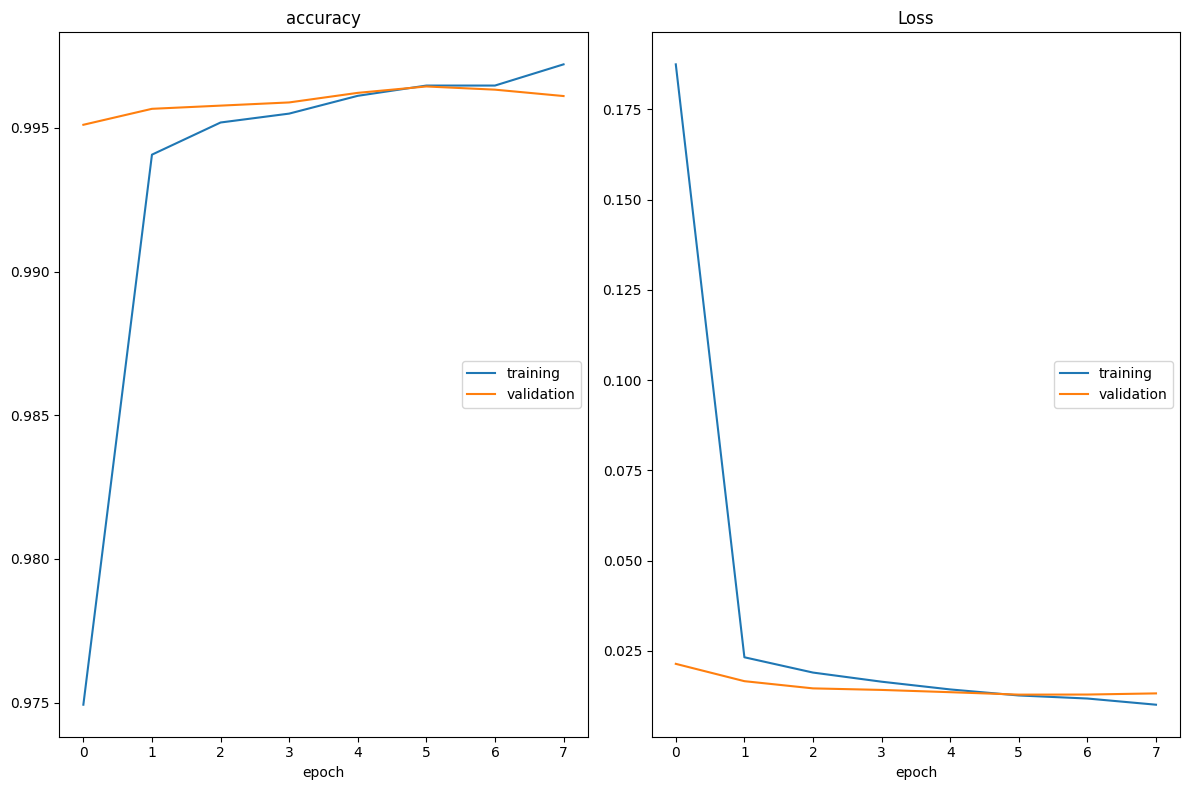

accuracy
	training         	 (min:    0.975, max:    0.997, cur:    0.997)
	validation       	 (min:    0.995, max:    0.996, cur:    0.996)
Loss
	training         	 (min:    0.010, max:    0.187, cur:    0.010)
	validation       	 (min:    0.013, max:    0.021, cur:    0.013)
1313/1313 [==============================] - 89s 68ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0133 - val_accuracy: 0.9961


In [22]:
# Definir el callback de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=2,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [23]:
# Creamos el directorio si no existe
model_dir = os.path.join("models","bert")
os.makedirs(model_dir, exist_ok=True)

# Guardamos el modelo entrenado
joblib.dump(model, os.path.join(model_dir,'bert_model1.joblib'))

/home/juan/miniconda3/envs/tf_complete/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


['models/bert/bert_model1.joblib']

### Guardar el modelo

In [ ]:
# Creamos el directorio si no existe
model_dir = os.path.join("models","bert")
os.makedirs(model_dir, exist_ok=True)

# # Guardamos el modelo entrenado
# joblib.dump(model, os.path.join(model_dir,'bert_model1.joblib'))

In [ ]:
# Cargar el modelo guardado
loaded_model = joblib.load(os.path.join(model_dir,'bert_model1.joblib'))


## 4. Fine-tuning del encoder 
Una vez que los pesos de la cabeza ya están más o menos ajustados, vamos a probar a hacer fine-tuning de los dos últimos bloques del transformer (y de la cabeza clasificadora).

In [ ]:
# Descongela todo el modelo primero
distilbert_model.trainable = True

# Congela las primeras 4 capas del encoder
# Solo haremos fine-tuning de las 2 últimas
for i in range(4):
    distilbert_model.distilbert.transformer.layer[i].trainable = False

# Veamos que ahora el número de parámetros entrenables ha aumentado
model.summary()

In [ ]:
# Compilar el modelo
# Empleamos Adam con Weight Decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5)  # Más bajo que el usado para entrenar la cabeza
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

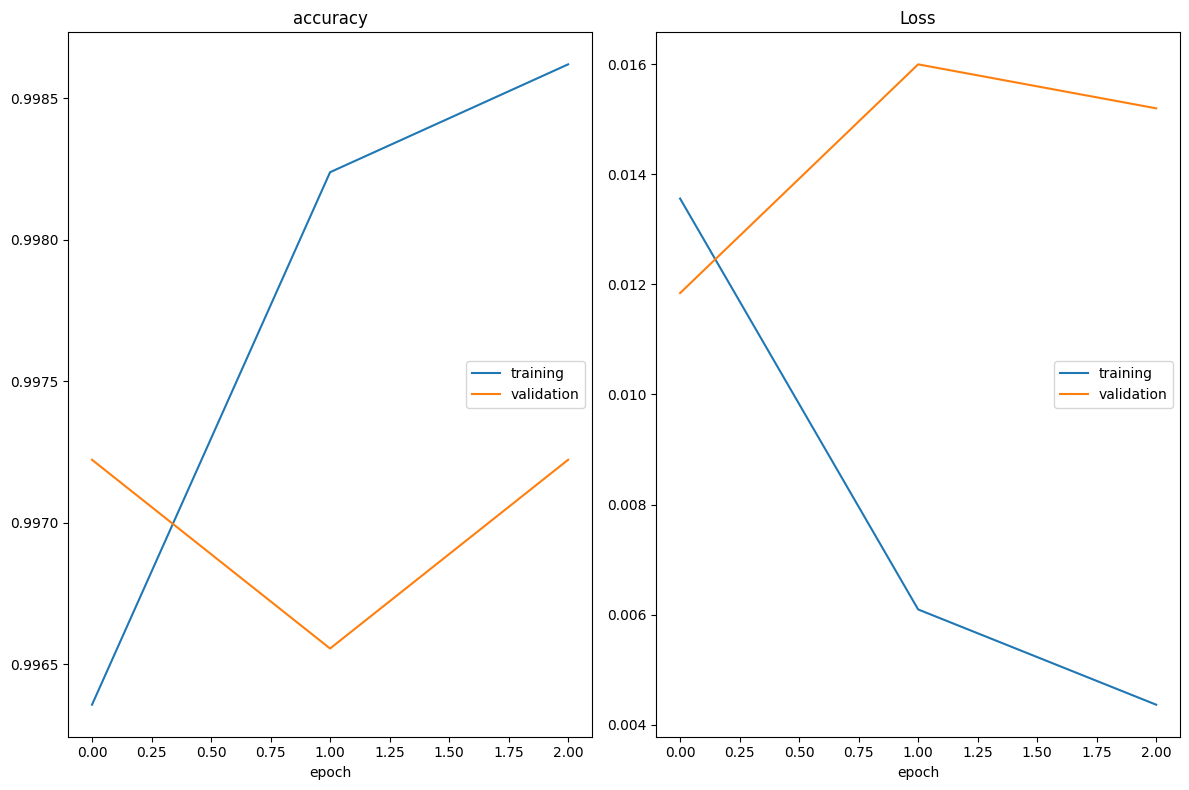

accuracy
	training         	 (min:    0.996, max:    0.999, cur:    0.999)
	validation       	 (min:    0.997, max:    0.997, cur:    0.997)
Loss
	training         	 (min:    0.004, max:    0.014, cur:    0.004)
	validation       	 (min:    0.012, max:    0.016, cur:    0.015)
1313/1313 [==============================] - 211s 161ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0152 - val_accuracy: 0.9972


In [ ]:
# Entrenamos el modelo

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

Reducir el tamaño de batch durante el entrenamiento, reducir la tasa de aprendizaje, aumentar la tasa de Dropout y aumentar la tasa de regularización podrian  ayudar a combatir el sobreajuste, llegando a alcanzar rendimientos superiores. Igualmente, aumentar el tamaño y la complejidad del dataset podrían ayudarnos a evitar igualmente el sobreajuste.

### Guardar el modelo

In [ ]:
# Creamos el directorio si no existe
model_dir = os.path.join("models","bert")
os.makedirs(model_dir, exist_ok=True)

# # Guardamos el modelo entrenado
# joblib.dump(model, os.path.join(model_dir,'bert_model_fine_tuned1.joblib'))

['models/bert/bert_model_fine_tuned1.joblib']

## 5. Evaluación

In [ ]:
# Hacemos las predicciones monitoreando la latencia del modelo
start = time.time()
preds = model.predict(test_dataset)
end = time.time()

preds_class = preds.argmax(axis = 1)
preds_str = le.inverse_transform(preds_class)

# Empleamos una función personalizada para ver un report del rendimiento
results_bert = classification_metrics_report(y_test, preds_str, df_test["n_words"])

# Latencia
latency_ms = (end - start) * 1000  # milisegundos
print(f"Latencia: {latency_ms:.2f} ms")

563/563 [==============================] - 49s 87ms/step
=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.996889         0.996894      0.996861  0.996873

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   0.994475 0.997230 0.995851      722
   da   0.998656 0.995979 0.997315      746
   de   0.997379 0.998688 0.998033      762
   el   1.000000 1.000000 1.000000      733
   es   0.993151 0.997249 0.995196      727
   fi   0.998726 0.998726 0.998726      785
   fr   0.997368 0.998682 0.998025      759
   it   0.993289 0.998650 0.995962      741
   pl   0.997271 0.993207 0.995235      736
   pt   0.998667 0.993369 0.996011      754
   sl   1.000000 0.990553 0.995254      741
   sv   0.993750 1.000000 0.996865      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  1.000000         1.000000      1.000000  1.000000
medium  0.999332         0.999312      0.999325  0.999318
 small  0.985923   

Lo primero y más evidente es que la latencia del modelo es mucho más alta que en los anteriores (40 veces más). También, hay que tener en cuenta que el modelo pesa mucho más y su entrenamiento lleva varias horas. Es necesario decir, que probablemente se podrían llegar a obtener mejores resultados si aplicásemos más regularización para evitar el sobreajuste.

In [ ]:
# Guardamos los resultados
with open(os.path.join(model_dir,"results.json"), "wb") as f:
    pickle.dump(results_bert, f)

## 6. Análisis de errores

In [31]:
def sorted_dict_probs(pred_probs:np.array):
    
    return dict(sorted(zip(le.classes_,np.round(pred_probs,3)), key=lambda x: x[1], reverse=True))

In [32]:
# Nos centramos en los errores
df_errors = df_test[preds_class!=y_test_enc].copy()

# Añadimos la clase predicha
df_errors.loc[:,"pred"] = [pred for pred, true in zip(preds_str, y_test) if pred != true]

# Añadimos las probabilidades
df_errors.loc[:,"scores"] = [sorted_dict_probs(preds[i]) for i in range(len(test_texts)) if preds_str[i]!=y_test[i]]

# Veamos los errores
df_errors

,text,language,n_words,pred,scores
155,Estou a contar convosco.\n,pt,4,es,"{'es': 0.735, 'pt': 0.264, 'cs': 0.0, 'da': 0...."
394,"(La sesión, suspendida a las 13.10 horas, se r...",pl,11,es,"{'es': 0.998, 'sl': 0.001, 'cs': 0.0, 'da': 0...."
1113,Lembro­me perfeitamente.\n,pt,3,it,"{'it': 0.42, 'es': 0.367, 'pt': 0.197, 'fr': 0..."
1728,Hvad får vi?\n,da,3,sv,"{'sv': 0.924, 'da': 0.076, 'cs': 0.0, 'de': 0...."
2112,(The sitting closed at 16.35)\n,sl,4,sv,"{'sv': 0.37, 'sl': 0.288, 'cs': 0.194, 'it': 0..."
2375,Citat slut.\n,da,2,sv,"{'sv': 0.993, 'da': 0.003, 'cs': 0.002, 'es': ..."
2578,(Posiedzenie zostało otwarte o godz.\n,pt,5,pl,"{'pl': 0.34, 'cs': 0.32, 'sl': 0.315, 'da': 0...."
2712,(Posiedzenie zostało otwarte o godz. 9.10)\n,pl,5,cs,"{'cs': 0.564, 'sl': 0.247, 'pl': 0.166, 'da': ..."
2806,Felicito-a!\n,pt,2,it,"{'it': 0.984, 'pt': 0.015, 'cs': 0.0, 'da': 0...."
3694,"""A-A.\n",pt,2,fr,"{'fr': 0.433, 'pt': 0.239, 'es': 0.112, 'it': ..."


- Confusión en los casos en los que aparecen varias lenguas:
    - Klimawandel (annonce de propositions de résolution déposées): siehe Protokoll
- Confusión cuando se introducen nombre de persona: 
    - "Poročilo: Miroslav Ouzký (A6-0395-2007)" etiquetado como esloveno pero clasificado como checo por el nombre
    - "Poročilo: Inés Ayala Sender" etiquetado como esloveno pero clasificado como español por el nombre

- Confusión entre las lenguas escandinavas y las lenguas romance.

- Errores en el corpus:
    - "Relazione: Herczog" etiquetado como checo, pero relazione no es una palabra en checo.
    - "(Posiedzenie zostało otwarte o godz." aparece etiquetada como portugués y el modelo detecta que es polaco
    - ... (ya comentados anteriormente)

- Errores sin sentido probablemente debidos a los signos de puntuación (probablemente mejor eliminarlos):
    - "(Posiedzenie zostało otwarte o godz." lo etiqueta como polaco
    - "(Posiedzenie zostało otwarte o godz. 9.10)" lo etiqueta como checo, y para el modelo la única diferencia son los signos de puntuación (los números se eliminan)


Ideas para futuros trabajos: 
    - Eliminar los signos de puntuación
    - Detectar y eliminar nombres propios podría también mejorar el modelo
    - Curar el corpus


### Pruebas
Hacemos algunas pruebas para ver el funcionamiento del modelo

In [33]:
text= "Hola buenos días" # Español
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 1s 678ms/step
Idioma detectado: es


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,1.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0


In [34]:
text= "Cómo" # Español
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 1s 679ms/step
Idioma detectado: es


,pred_probs
cs,0.00
da,0.00
de,0.00
el,0.00
es,0.86
fi,0.00
fr,0.00
it,0.00
pl,0.00
pt,0.14


In [35]:
text = "Nicht" # Alemán 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 30ms/step
Idioma detectado: de


,pred_probs
cs,0.0
da,0.0
de,1.0
el,0.0
es,0.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0


In [36]:
text = "Ça ne marche pas" # Francés 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 32ms/step
Idioma detectado: fr


,pred_probs
cs,0.00
da,0.00
de,0.00
el,0.00
es,0.01
fi,0.00
fr,0.98
it,0.00
pl,0.00
pt,0.00


In [37]:
text = "Ça ne marche pas, je suis desolé" # Francés 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 31ms/step
Idioma detectado: fr


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,0.0
fi,0.0
fr,1.0
it,0.0
pl,0.0
pt,0.0


In [38]:
text = "Det fungerar inte." # Sueco
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 33ms/step
Idioma detectado: sv


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,0.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0
